In [76]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

DATASET_PATH = "lfw"
"""
Hi, this value can be changed according to the model used Okeee, so don't tell me that i didn't warn you
if you found out that your model doesn't work properly, Bye :)
"""
IMG_SIZE = 224 
BATCH_SIZE = 32

In [77]:
# each celebrity images' are inside a folder with that celibrity's name 
celebs = [celebrity for celebrity in os.listdir(DATASET_PATH) 
          if os.path.isdir(os.path.join(DATASET_PATH, celebrity))]
#creates IDs for each celebrity
label_map = {celebrity: id for id, celebrity in enumerate(celebs)}

In [78]:
# remove corrupted images
for celebrity in celebs:
    celebrity_path = os.path.join(DATASET_PATH, celebrity)
    for img_name in os.listdir(celebrity_path):
        img_path = os.path.join(celebrity_path, img_name)
        try:
            img = Image.open(img_path)
            img.verify()
        except:
            print("Removing corrupted:", img_path)
            os.remove(img_path)

In [79]:
# build dataset arrays, one for image paths => "lfw/Brad_Pitt/0001.jpg" and the other for storing labels => [0, 0, 1, ...]
image_paths = []
labels = []

for celebrity in celebs:
    celebrity_path = os.path.join(DATASET_PATH, celebrity)
    for img_name in os.listdir(celebrity_path):
        image_paths.append(os.path.join(celebrity_path, img_name))
        labels.append(label_map[celebrity])

# turn them into numpy
image_paths = np.array(image_paths)
labels = np.array(labels, dtype=np.int32)

In [80]:
# randomize images before splitting into train/val/test
indices = np.arange(len(image_paths))
np.random.seed(42)   # to get the same random shuffle every time you run the code
np.random.shuffle(indices)

image_paths = image_paths[indices]
labels = labels[indices]

In [81]:
# splitting into training (70%), validation (15%)& testing sets (15%)
train_end = int(0.7 * len(image_paths))
val_end   = int(0.85 * len(image_paths))

train_paths = image_paths[:train_end]
val_paths   = image_paths[train_end:val_end]
test_paths  = image_paths[val_end:]

train_labels = labels[:train_end]
val_labels   = labels[train_end:val_end]
test_labels  = labels[val_end:]

In [83]:
# data augmentation for only training set
# `p` means is the percentage/chance of applying to each image
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),    # flip image horizontally, 50% probability
    A.Rotate(limit=20, p=0.5),  # rotate ±20 degrees, 50% probability
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),    # for different lighting conditions
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),    # for face positioning variations
    A.GaussianBlur(blur_limit=3, p=0.2),    # for motion blur, out-of-focus images
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.3),    #for color variations
])


In [84]:
# load image and preprocess because neural networks work with fixed-size tensors only
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0    # normalize to [0..1]
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return image, label


In [85]:
# use Albumentations inside a TensorFlow pipeline.
def augment_np(image, label):
    # convert float32 0..1 → uint8
    image = (image * 255.0).numpy().astype("uint8")

    aug = train_transform(image=image)["image"]

    # convert back to float32 0..1
    aug = aug.astype("float32") / 255.0

    return aug, label

def tf_augment(image, label):
    image, label = tf.py_function(
        func=augment_np,
        inp=[image, label],
        Tout=(tf.float32, tf.int32)
    )
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    label.set_shape(())
    return image, label

In [86]:
# normalization depending on the type of the model
def model_normalize(image, label, model_type="resnet"):
    if model_type in ["resnet", "mobilenet", "vit"]:
        # ImageNet mean/std
        mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
        std  = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
        image = (image - mean) / std

    elif model_type == "inception_v3" or model_type == "inception_v1":
        image = (image - 0.5) * 2.0  # [-1, 1]

    elif model_type == "none":  # VGG-19 from scratch
        pass  # keep 0..1

    return image, label

In [87]:
# creating preproccessed dataset
def create_dataset(paths, labels, model_type='resnet', augment=False, shuffle=True):

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    # load & scale (0..1)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    # augment only training
    if augment:
        ds = ds.map(tf_augment, num_parallel_calls=tf.data.AUTOTUNE)

    # then apply model normalization
    ds = ds.map(lambda x, y: model_normalize(x, y, model_type),
                num_parallel_calls=tf.data.AUTOTUNE)

    # shuffle → batch → prefetch
    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return ds

In [88]:
"""
TEST CREATING DATASET FOR MODELS, SO FOLLOW THIS SAME SCHEMA PLEASE, IF YOU WANT TO CHANGE
THE MODEL YOU CAN ONLY CHANGE THE `model_type` VALUE OKEEE?
  VGG => none
  ResNet => resnet
  inception => inception_v3 or inception_v1 
  MobileNet => mobilenet
  ViT => vit
"""
train_dataset = create_dataset(train_paths, train_labels, model_type="resnet", augment=True)
val_dataset   = create_dataset(val_paths,   val_labels,   model_type="resnet", augment=False, shuffle=False)
test_dataset  = create_dataset(test_paths,  test_labels,  model_type="resnet", augment=False, shuffle=False)


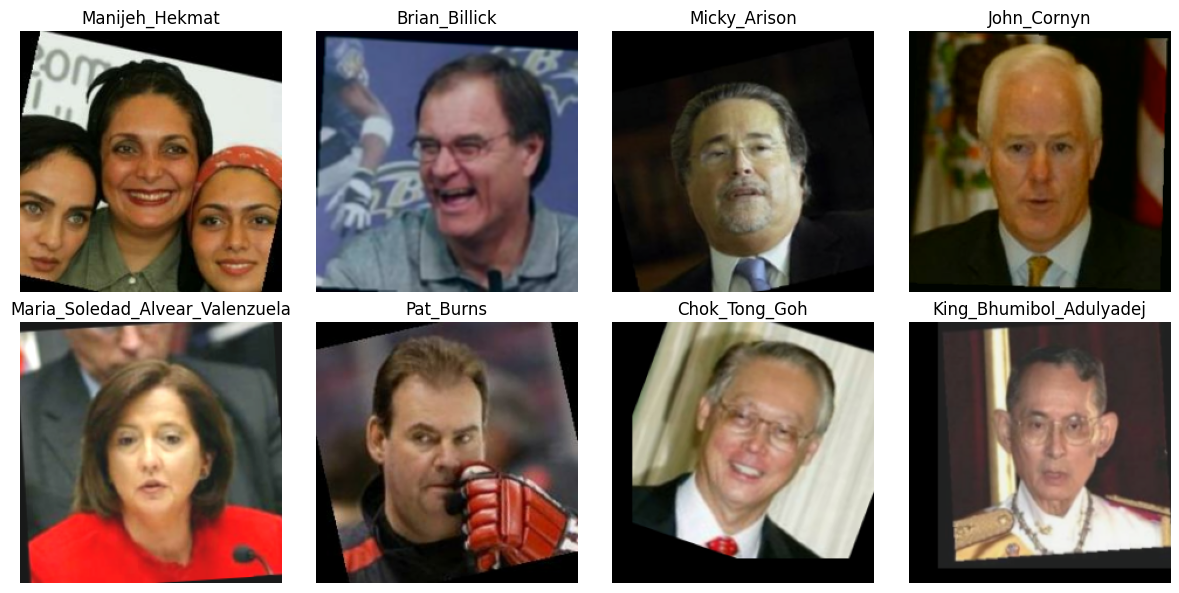

In [89]:
# testing image plot, at the beggining when i tested it the images were all reddish TwT but thank god i could fix it :)
def plot_batch(dataset, label_map, n=6):
    images, labels = next(iter(dataset))

    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n//2, i+1)

        # Reverse any model normalization for display
        img = images[i].numpy()

        # If image is normalized for ImageNet (ResNet, ViT, MobileNet)
        if img.min() < 0:
            mean = np.array([0.485, 0.456, 0.406])
            std  = np.array([0.229, 0.224, 0.225])
            img = img * std + mean   # undo normalize

        # If image in [-1, 1] (Inception)
        if img.min() < -0.1:
            img = (img + 1) / 2.0

        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(list(label_map.keys())[labels[i].numpy()])
        plt.axis("off")

    plt.tight_layout()
    plt.show()
plot_batch(train_dataset, label_map, n=8)

In [90]:
# test the pipeline
for images, labels in train_dataset.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Image range: [{tf.reduce_min(images):.3f}, {tf.reduce_max(images):.3f}]")
    print(f"Labels: {labels[:5].numpy()}")

Batch shape: (32, 224, 224, 3)
Image range: [-2.118, 2.640]
Labels: [2283 5526 4057 4551 4416]
